<a href="https://colab.research.google.com/github/negrete-93/Extraordinario_EDPII/blob/main/Extraordinario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Examen extraordinario

Usando un método de elementos finitos lineales con cuatro elementos, calcule la matriz de rigidez K y el vector de cargas F para el problema de valor en la frontera

$$
-u''(x)=1-x^2,\quad 0<x<1 ,\quad u(0)=u(1)=0
$$

Resuelva para $U_N$ y compare $U_N$ con u.

In [34]:
#Importamos las librerías necesarias
import sympy as sp
import numpy as np
import pandas as pd


In [5]:
#Se inicializa el modo de SymPy para visualizar las expresiones simbólicas en notación estándar.
sp.init_printing()

#Se define la variable simbólica
x = sp.Symbol('x', real=True)

Construimos nuestra solución analítica

Partimos de:
$$
-u''(x)=1-x^2 \quad\Rightarrow\quad u''(x)=x^2-1
$$

Integramos dos veces y aplicamos condiciones de frontera:
$$
u''=x^2-1
\Rightarrow
u'=\frac{x^3}{3}-x + C_1
\Rightarrow
u=\frac{x^4}{12}-\frac{x^2}{2}+C_1 x + C_2
$$

Con $u(0)=0\Rightarrow C_2=0$ y $u(1)=0\Rightarrow \frac{1}{12}-\frac{1}{2}+C_1=0\Rightarrow C_1=\frac{5}{12}$

Entonces:
$$
u(x)=\frac{x^4}{12}-\frac{x^2}{2}+\frac{5}{12}x
$$


In [6]:
u = sp.Function('u')

#Se define la ecuación
ode = sp.Eq(sp.diff(u(x), x, 2), x**2 - 1)

sol_general = sp.dsolve(ode)
sol_general


                    4    2
                   x    x 
u(x) = C₁ + C₂⋅x + ── - ──
                   12   2 

In [7]:
C1, C2 = sp.symbols('C1 C2')
u_general = sol_general.rhs

#Reescribimos para resolver las constantes
u_general_simpl = sp.simplify(u_general)
u_general_simpl


             4    2
            x    x 
C₁ + C₂⋅x + ── - ──
            12   2 

In [8]:
#Extraemos las constantes de integración

u_trial = x**4/sp.Integer(12) - x**2/sp.Integer(2) + C1*x + C2

eqs = [
    sp.Eq(u_trial.subs(x, 0), 0),
    sp.Eq(u_trial.subs(x, 1), 0)
]
sp.solve(eqs, (C1, C2))


{C₁: 5/12, C₂: 0}

In [9]:
#Obtenemos la sol exacta

consts = sp.solve(eqs, (C1, C2))
u_exact = sp.simplify(u_trial.subs(consts))
u_exact


  ⎛ 3          ⎞
x⋅⎝x  - 6⋅x + 5⎠
────────────────
       12       

Graficamos

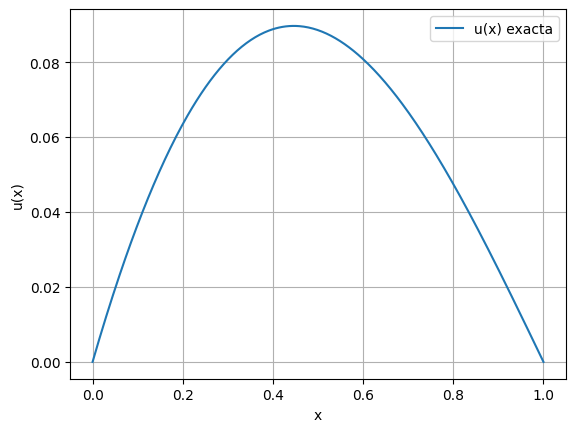

In [10]:
u_exact_fun = sp.lambdify(x, u_exact, 'numpy')

xx = np.linspace(0, 1, 400)
plt.figure()
plt.plot(xx, u_exact_fun(xx), label='u(x) exacta')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()


##Método del Elemento Finito 1D con elementos lineales

###Formulación débil

Dado:

$$
-u''(x)=f(x),\quad f(x)=1-x^2
$$

Multiplicamos por una función de prueba $v(x)\$ con \$v(0)=v(1)=0\$ e integramos:

$$
\int_0^1 (-u'')v\,dx = \int_0^1 f v\,dx
$$

Integramos por partes usando \$v(0)=v(1)=0\$:

$$
\int_0^1 u'v'\,dx=\int_0^1 f v\,dx
$$

###Aproximación del Método del Elemento Finito

Dividimos $[0,1]$ en 4 elementos $h=0.25$ con nodos:

$$
x_0=0,\ x_1=0.25,\ x_2=0.5,\ x_3=0.75,\ x_4=1
$$

Buscamos:

$$
u_N(x)=\sum_{i=0}^{4} U_i\,\phi_i(x)
$$

donde $\phi_i$ son funciones "sombrero" y
$U_0=U_4=0$ por Dirichlet.

El sistema lineal es:

$$
K\,U = F
$$
con
$$
K_{ij}=\int_0^1 \phi_i'(x)\phi_j'(x)\,dx,\qquad
F_i=\int_0^1 f(x)\phi_i(x)\,dx
$$

###Fórmulas locales (elemento lineal)
En un elemento $[x_e, x_{e+1}]$ de longitud $h$:
$$
K^{(e)}=\frac{1}{h}
\begin{pmatrix}
1 & -1\\
-1 & 1
\end{pmatrix}
$$

y el vector local:
$$
F^{(e)}_i=\int_{x_e}^{x_{e+1}} f(x)\,\psi_i(x)\,dx
$$
donde $(\psi_1,\psi_2) $son las funciones de forma del elemento.


In [11]:
#Datos del problema
f = 1 - x**2

#Construimos los nodos de la malla
nodes = [sp.Rational(0), sp.Rational(1,4), sp.Rational(1,2), sp.Rational(3,4), sp.Rational(1)]
n_nodes = len(nodes)
n_elems = n_nodes - 1

nodes


[0, 1/4, 1/2, 3/4, 1]

In [17]:
#Definimos las funciones de forma lineales en un elemento finito

def local_shape_functions(xe, xe1):
    """Funciones de forma lineales en [xe, xe1]."""
    h = xe1 - xe
    psi1 = (xe1 - x)/h
    psi2 = (x - xe)/h
    return psi1, psi2, h

#Definimos la matriz de rigidez local
def local_stiffness(h):
    """K local para -u''=f con elementos lineales."""
    return (1/h) * sp.Matrix([[1, -1], [-1, 1]])


In [18]:
#Calculamos el vector de carga local
def local_load_vector(xe, xe1, f_expr):
    psi1, psi2, h = local_shape_functions(xe, xe1)
    F1 = sp.integrate(f_expr*psi1, (x, xe, xe1))
    F2 = sp.integrate(f_expr*psi2, (x, xe, xe1))
    return sp.Matrix([sp.simplify(F1), sp.simplify(F2)])


Contruimos K y F correspondientemente

In [24]:
K = sp.zeros(n_nodes, n_nodes)
F = sp.zeros(n_nodes, 1)

for e in range(n_elems):
    xe = nodes[e]
    xe1 = nodes[e+1]
    psi1, psi2, h = local_shape_functions(xe, xe1)

    Ke = local_stiffness(h)
    Fe = local_load_vector(xe, xe1, f)

    # Mapeo local->global (nodos e y e+1)
    idx = [e, e+1]

    # Ensamblaje
    for a in range(2):
        for b in range(2):
            K[idx[a], idx[b]] += Ke[a,b]
        F[idx[a], 0] += Fe[a, 0]

K_simpl = sp.simplify(K)
F_simpl = sp.simplify(F)

K_simpl,F_simpl


⎛                      ⎡ 95  ⎤⎞
⎜                      ⎢ ─── ⎥⎟
⎜                      ⎢ 768 ⎥⎟
⎜                      ⎢     ⎥⎟
⎜⎡4   -4  0   0   0 ⎤  ⎢ 89  ⎥⎟
⎜⎢                  ⎥  ⎢ ─── ⎥⎟
⎜⎢-4  8   -4  0   0 ⎥  ⎢ 384 ⎥⎟
⎜⎢                  ⎥  ⎢     ⎥⎟
⎜⎢0   -4  8   -4  0 ⎥, ⎢ 71  ⎥⎟
⎜⎢                  ⎥  ⎢ ─── ⎥⎟
⎜⎢0   0   -4  8   -4⎥  ⎢ 384 ⎥⎟
⎜⎢                  ⎥  ⎢     ⎥⎟
⎜⎣0   0   0   -4  4 ⎦  ⎢ 41  ⎥⎟
⎜                      ⎢ ─── ⎥⎟
⎜                      ⎢ 384 ⎥⎟
⎜                      ⎢     ⎥⎟
⎝                      ⎣5/256⎦⎠

Aplico Dirichlet y resolvemos el sistema

### Condiciones esenciales (de Dirichlet)

Se imponen:
$$
U_0=u(0)=0,\qquad U_4=u(1)=0
$$

Por tanto, resolvemos el sistema reducido para los nodos interiores $(U_1,U_2,U_3)$:

$$
K_{red}\,U_{int} = F_{red}
$$


In [25]:
# Índices interiores (1,2,3)
interior = [1,2,3]

K_red = K_simpl.extract(interior, interior)
F_red = F_simpl.extract(interior, [0])
# solución simbólica exacta
U_int = sp.Matrix(K_red.LUsolve(F_red))
U_int_simpl = sp.simplify(U_int)

U_int_simpl


⎡ 75 ⎤
⎢────⎥
⎢1024⎥
⎢    ⎥
⎢17  ⎥
⎢─── ⎥
⎢192 ⎥
⎢    ⎥
⎢ 59 ⎥
⎢────⎥
⎣1024⎦

In [26]:
# Construimos el vector completo
U = sp.Matrix([0, U_int_simpl[0], U_int_simpl[1], U_int_simpl[2], 0])
U


⎡ 0  ⎤
⎢    ⎥
⎢ 75 ⎥
⎢────⎥
⎢1024⎥
⎢    ⎥
⎢17  ⎥
⎢─── ⎥
⎢192 ⎥
⎢    ⎥
⎢ 59 ⎥
⎢────⎥
⎢1024⎥
⎢    ⎥
⎣ 0  ⎦

##Solución aproximada \(u_N(x)\)

Como el FEM es lineal por elemento, $u_N(x)$ se define por tramos:

en cada elemento $[x_e,x_{e+1}]$

$$
u_N(x)=U_e\,\psi_1(x)+U_{e+1}\,\psi_2(x)
$$
con $(\psi_1,\psi_2)$ lineales.


Obtenemos La función global $u_N$

In [27]:
pieces = []

#Recorre todos los elementos finitos de la malla para obtener los extremos del elemento actual

for e in range(n_elems):
    xe = nodes[e]
    xe1 = nodes[e+1]
    psi1, psi2, h = local_shape_functions(xe, xe1)
    u_e = sp.simplify(U[e]*psi1 + U[e+1]*psi2)
    cond = sp.And(x >= xe, x <= xe1) if e == n_elems-1 else sp.And(x >= xe, x < xe1)
    pieces.append((u_e, cond))

uN = sp.Piecewise(*pieces)
uN


⎧   75⋅x                           
⎪   ────       for x ≥ 0 ∧ x < 1/4 
⎪   256                            
⎪                                  
⎪47⋅x    89                        
⎪──── + ────  for x ≥ 1/4 ∧ x < 1/2
⎪768    1536                       
⎨                                  
⎪77    95⋅x                        
⎪─── - ────   for x ≥ 1/2 ∧ x < 3/4
⎪512   768                         
⎪                                  
⎪59    59⋅x                        
⎪─── - ────    for x ≥ 3/4 ∧ x ≤ 1 
⎩256   256                         

Graficamos

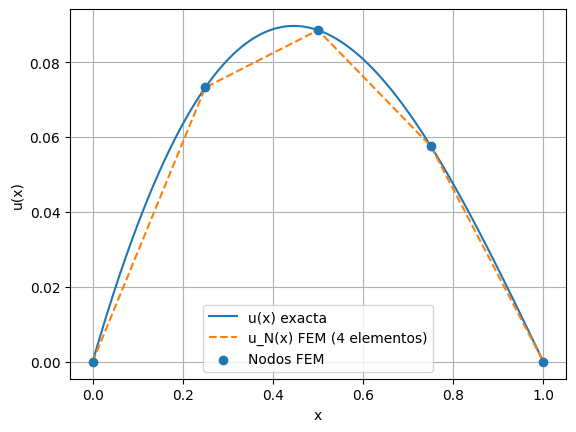

In [28]:
uN_fun = sp.lambdify(x, uN, 'numpy')

xx = np.linspace(0, 1, 400)
plt.figure()
plt.plot(xx, u_exact_fun(xx), label='u(x) exacta')
plt.plot(xx, uN_fun(xx), '--', label='u_N(x) FEM (4 elementos)')
plt.scatter([float(n) for n in nodes], [float(val) for val in U], zorder=5, label='Nodos FEM')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()


In [32]:
#Se evalúa la solución exacta en cada nodo
u_exact_nodes = [sp.N(u_exact.subs(x, xi)) for xi in nodes]
uN_nodes = [sp.N(U[i]) for i in range(n_nodes)]

#Se calcula el error nodal en cada punto:
err_nodes = [sp.N(uN_nodes[i] - u_exact_nodes[i]) for i in range(n_nodes)]


Ahora construimos una tabla simbólica, cada fila corresponde a un nodo de la malla.

In [33]:
table = sp.Matrix([
    [nodes[i], u_exact_nodes[i], uN_nodes[i], err_nodes[i], abs(err_nodes[i])]
    for i in range(n_nodes)
])

table


⎡ 0           0                   0           0  0⎤
⎢                                                 ⎥
⎢1/4     0.0732421875        0.0732421875     0  0⎥
⎢                                                 ⎥
⎢1/2  0.0885416666666667  0.0885416666666667  0  0⎥
⎢                                                 ⎥
⎢3/4     0.0576171875        0.0576171875     0  0⎥
⎢                                                 ⎥
⎣ 1           0                   0           0  0⎦

### Tabla de comparación numérica


In [35]:
df = pd.DataFrame({
    "x_i": [float(n) for n in nodes],
    "u(x_i) exacta": [float(v) for v in u_exact_nodes],
    "u_N(x_i) FEM": [float(v) for v in uN_nodes],
    "error": [float(v) for v in err_nodes],
    "|error|": [float(abs(v)) for v in err_nodes],
})

df


,x_i,u(x_i) exacta,u_N(x_i) FEM,error,|error|
0,0.00,0.000000,0.000000,0.0,0.0
1,0.25,0.073242,0.073242,0.0,0.0
2,0.50,0.088542,0.088542,0.0,0.0
3,0.75,0.057617,0.057617,0.0,0.0
4,1.00,0.000000,0.000000,0.0,0.0


La solución exacta obtenida es:
$$
u(x)=\frac{x^4}{12}-\frac{x^2}{2}+\frac{5}{12}x
$$

Con 4 elementos lineales, el Método de Elemento Finito produce una aproximación por tramos que coincide con la exacta en los extremos y aproxima bien en los nodos interiores.
